In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
import torch
from torch.nn import MSELoss
from torchvision import transforms
from PIL import Image
from monai.networks.blocks import Warp
from monai.networks.nets import GlobalNet
from monai.losses import BendingEnergyLoss
import numpy as np
import matplotlib.pyplot as plt

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip -qq /content/drive/MyDrive/MRI_data/2Dfat_3333.zip;
!unzip -qq /content/drive/MyDrive/MRI_data/fatnavData.zip;

In [ ]:
device = torch.device("cuda:0")
convert_tensor = transforms.ToTensor()

p = 101 #how many images from each dataset to use to train + 1 (max 101)
q = 33 #number of datasts to use (max 33)
fn =[ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0,q):
  for v in range(0, p):
    n = i+1
    image = Image.open(f'/content/train_{n}/00{v}_rt.png')
    image = convert_tensor(image)
    image1 = image.unsqueeze(0)
    image1 = image1.to(device)
    fn[i].append(image1)

In [ ]:
#translations parameters - x and y are swapped for these coordinates vs mri ones, rotations are clockwise in degrees
rotations = [ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
translations_x = [ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
translations_y = [ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0, q):
  rotations[i].append(0)
  translations_x[i].append(0)
  translations_y[i].append(0)
  for v in range(1, p):
    n = i + 1
    with open(f"/content/train_{n}/00{v}_augments.txt") as f:
        lines = f.readlines()
        line0 = lines[0]
        r1 = float(line0.split("=")[1])
        #convert to radians
        r1 = (r1*np.pi)/180
        rotations[i].append(r1)
        line1 = lines[1]
        t1 = float(line1.split("=")[1])
        translations_y[i].append(-t1)
        line2 = lines[2]
        t2 = float(line2.split("=")[1])
        #-ve sign?
        translations_x[i].append(t2)

In [ ]:
ddfs = [ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0, q):
  for (tx, ty, r) in zip(translations_x[i], translations_y[i], rotations[i]):
    image_width = 128
    image_height = 128

    # Create mesh grid
    x, y = np.meshgrid(range(image_height), range(image_width), indexing='ij')

    # Initialize tensor
    displacement_field = np.zeros((image_height, image_width, 2))

    # Apply transformation parameters - affine transformation matrix: [[cos(r), sin(r), Tx], [-sin(r), cos(r), Ty]]
    homogeneous_coordinates = np.stack([x.flatten(), y.flatten(), np.ones_like(x.flatten())])
    transformation_matrix = np.array([[np.cos(r), np.sin(r), tx], [-np.sin(r), np.cos(r), ty]])
    transformed_homogeneous_coordinates = transformation_matrix @ homogeneous_coordinates

    # Compute displacement field
    displacement_field[..., 0] = transformed_homogeneous_coordinates[0].reshape((image_height, image_width)) - x
    displacement_field[..., 1] = transformed_homogeneous_coordinates[1].reshape((image_height, image_width)) - y

    displacementfield0 = torch.tensor(displacement_field)
    displacementfield = displacementfield0.unsqueeze(0)
    displacementfield = displacementfield.permute(0, 3, 1, 2)
    displacementfield = displacementfield.to(device)
    ddfs[i].append(displacementfield)

#print(ddfs[1])
  

In [ ]:
activation = {}


def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()

    return hook

def custom_loss(result, displacementfield):
    return torch.mean((result - displacementfield)**2)

input_param = {
    "image_size": (128, 128),
    "spatial_dims": 2,
    "in_channels": 2,
    "num_channel_initial": 16,
    "depth": 3,
}
net = GlobalNet(**input_param).to(device)
net.output_block.fc.register_forward_hook(get_activation("fc"))
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-5)

In [ ]:
def custom_loss1(result, displacementfield):
  transformed_points = fixed1 + result
  ground_truth_points = fixed1 + displacementfield

  # Compute Chamfer distance between transformed points and ground truth points
  return (torch.mean(torch.min(torch.sum((transformed_points[:, None, :] - ground_truth_points[None, :, :])**2, dim=2), dim=1).values) + torch.mean(torch.min(torch.sum((ground_truth_points[:, None, :] - transformed_points[None, :, :])**2, dim=2), dim=1).values))/2


Train

In [ ]:
max_epochs = 100
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    net.train()
    epoch_loss, step = 0, 0
    for i in range(0, 33):
      for (moving1, displacementfield) in zip(fn[i], ddfs[i]):
          step += 1
          optimizer.zero_grad()
          result = net(torch.cat((fn[i][0], moving1), dim=1))
          loss = custom_loss(result, displacementfield) + 100 * regularization(result) #was 10 previously
          #loss = custom_loss1(result, displacementfield)
          #loss = customloss2(result, transmat)

          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/100
epoch 1 average loss: 47.4418
----------
epoch 2/100
epoch 2 average loss: 228.3324
----------
epoch 3/100
epoch 3 average loss: 246.1448
----------
epoch 4/100
epoch 4 average loss: 253.7428
----------
epoch 5/100
epoch 5 average loss: 526.7783
----------
epoch 6/100
epoch 6 average loss: 458.6330
----------
epoch 7/100
epoch 7 average loss: 166.1197
----------
epoch 8/100
epoch 8 average loss: 135.6437
----------
epoch 9/100
epoch 9 average loss: 233.7431
----------
epoch 10/100
epoch 10 average loss: 571.7229
----------
epoch 11/100
epoch 11 average loss: 704.8219
----------
epoch 12/100
epoch 12 average loss: 403.8662
----------
epoch 13/100
epoch 13 average loss: 231.7191
----------
epoch 14/100
epoch 14 average loss: 169.8168
----------
epoch 15/100
epoch 15 average loss: 130.2844
----------
epoch 16/100
epoch 16 average loss: 113.3249
----------
epoch 17/100
epoch 17 average loss: 132.8945
----------
epoch 18/100
epoch 18 average loss: 196.2516
----------


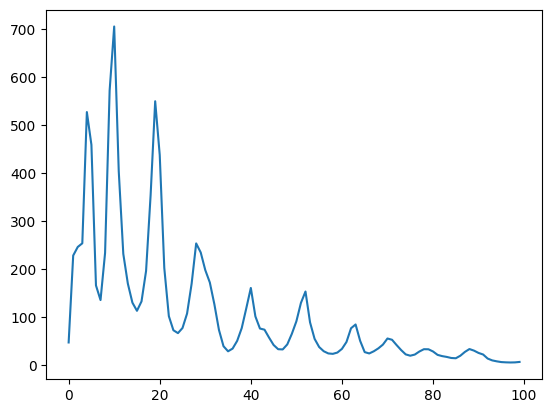

In [ ]:
%matplotlib inline
plt.plot(epoch_loss_values)

Now with validation data

In [ ]:
numbers = [9, 10, 10, 4, 4, 4, 4, 4, 4, 10, 10, 4, 4, 4, 4, 4, 4, 4, 6, 6, 4, 4, 6, 6, 4, 4, 4, 4, 4, 6, 6, 6, 6]
fn1 =[ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0,33):
  for v in range(0, numbers[i] + 1):
    n = i+1
    image = Image.open(f'/content/fn_{n}/00{v}_fatNavRecon.png')
    image = convert_tensor(image)
    image1 = image.unsqueeze(0)
    image1 = image1.to(device)
    fn1[i].append(image1)

In [ ]:
activations = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0,33):
  for image1 in fn1[i]:
    fixed2 = fn1[i][0]
    ddf = net(torch.cat((image1, fixed2), dim=1))
    activations[i].append(activation['fc'])

In [ ]:
import timeit
start = timeit.default_timer()
predx = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
predy = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
predr = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

for i in range(0,33):
  for activation in activations[i]:
    a = activation[0,2].item()
    predx[i].append(a)

    b = activation[0,5].item()
    predy[i].append(b)

    c = activation[0, 0].item()
    d = activation[0, 1].item()
    e = activation[0, 3].item()
    f = activation[0, 4].item()

    g = (np.arcsin(d) + np.arcsin(-e))/2
    predr[i].append(g)

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  0.034806751000019176


In [ ]:
#translations parameters for test data
#y:
test_x = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
test_y = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
test_r = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0, 33):
  test_x[i].append(0)
  test_y[i].append(0)
  test_r[i].append(0)
  for v in range(1, numbers[i] + 1):
    n = i + 1
    with open(f"/content/fn_{n}/reg_00{v}.txt") as f:
        lines = f.readlines()
        line0 = lines[0]
        r1 = float(line0.split("=")[1])
        #convert to radians
        test_r[i].append(r1)
        line1 = lines[1]
        t1 = float(line1.split("=")[1])
        test_x[i].append(t1)
        line2 = lines[2]
        t2 = float(line2.split("=")[1])
        test_y[i].append(t2)

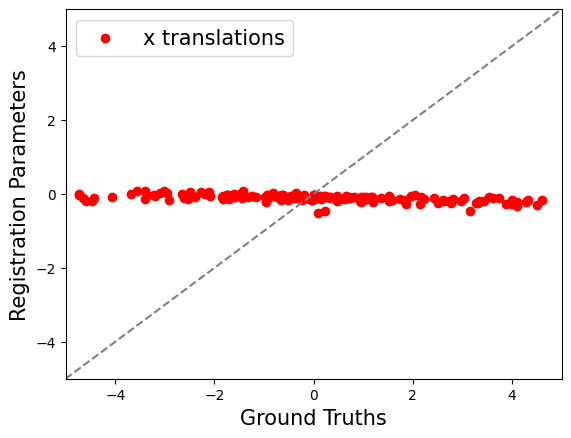

In [ ]:
%matplotlib inline
for i in range (0, 33):
  plt.scatter(test_x[i], predx[i], color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.legend(['x translations'],fontsize=15, loc='upper left')

plt.plot([-5, 5], [-5, 5], linestyle='--', color='gray')

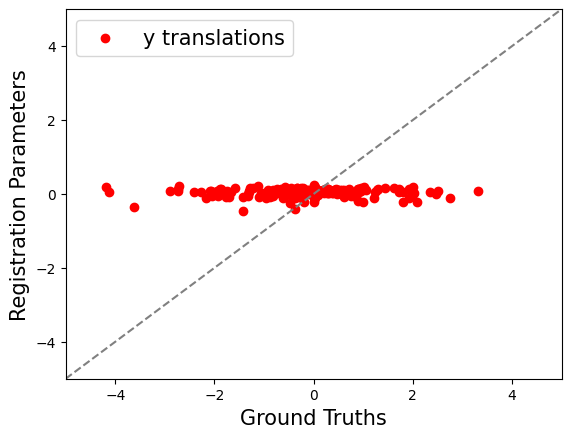

In [ ]:
%matplotlib inline
for i in range (0, 33):
  plt.scatter(test_y[i], predy[i], color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.legend(['y translations'],fontsize=15, loc='upper left')

plt.plot([-5, 5], [-5, 5], linestyle='--', color='gray')

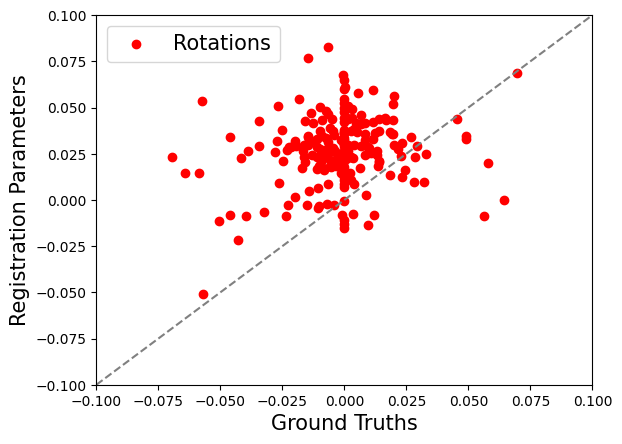

In [ ]:
%matplotlib inline
for i in range (0, 33):
  plt.scatter(test_r[i], predr[i], color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])

plt.legend(['Rotations'],fontsize=15, loc='upper left')

plt.plot([-0.1, 0.1], [-0.1, 0.1], linestyle='--', color='gray')

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/MRI_data/2D_new_fattest_1.pth')

Testing section